In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
config.H_target = 2* 0.3
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

# Load Critic Dataset

In [4]:
def get_crit_data(bs= 32, size=(336, 336)):
    path = "../src/dsin"
 
    kitti_stats = ([0.367, 0.385, 0.372], [0.288, 0.298, 0.301]) # mean, std

    data_image = (ImageList.from_csv(path=path, cols = 'name', csv_name = 'DISC_KITTI_TOT.txt')
                     .split_by_rand_pct(0.1, seed=42)
                     .label_from_df(cols='label')
                     .transform(None, size=size, resize_method=ResizeMethod.CROP)
                     .databunch(bs=bs)
                     .normalize(kitti_stats))
    #     data_image.c = 3
    data_image
    return data_image

In [5]:
# data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

data_crit = get_crit_data(bs = 4)

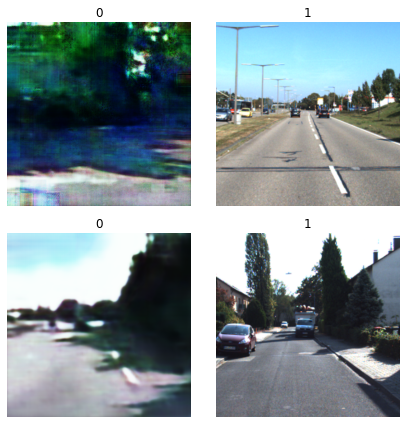

In [6]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)


In [7]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())


# Create Critic

In [8]:
wd = 1e-3
learn_critic = Learner(data_crit, gan_critic(), metrics=accuracy_thresh_expand, loss_func=loss_critic, wd=wd)

In [9]:
learn_critic.fit_one_cycle(6, 1e-3)
input()

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.383992,0.142646,0.957865,01:19
1,0.123530,0.139144,0.945773,01:20
2,0.051214,0.078826,0.989959,01:20
3,0.055824,0.036005,0.987459,01:20
4,0.047510,0.019032,0.994179,01:20


KeyboardInterrupt: 

In [14]:
! ls ../src/dsin/models

20200818-critic-pre-gan.pth


In [15]:
model_fname = '20200818-critic-pre-gan'
learn_critic.save(model_fname)
!aws s3 cp ~/tDSIN/src/dsin/models/{model_fname}.pth  s3://dsin-us/models/


upload: ../src/dsin/models/20200818-critic-pre-gan.pth to s3://dsin-us/models/20200818-critic-pre-gan.pth


# GAN

In [ ]:
learn_crit=None
gc.collect()

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [ ]:
learn_critic = Learner(data, gan_critic(), metrics=None, loss_func=loss_critic, wd=wd)

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4

In [ ]:
learn.fit(40,lr)


In [ ]:
learn.save('gan-1c')
